In [42]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}


<IPython.core.display.Javascript object>

In [43]:
# All comments provided insinde code cells for an easier exporting to the .py - files
%matplotlib notebook
%matplotlib notebook
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from pathlib import Path
from scipy.interpolate import UnivariateSpline
from scipy.integrate import quad
from numpy import savetxt
import copy
import pandas as pd
import matplotlib.colors as mcolors
import re
import io
from IPython.display import display, clear_output
from matplotlib import ticker
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator)



In [44]:
def subplot_axes_ticks_tuning(_AxesSubplot):
    _AxesSubplot.tick_params(axis = 'both',
                        which = 'major',
                        direction = 'in',
                        length = 5,
                        width = 2,
                        labelsize = 14
                        )

    _AxesSubplot.tick_params(axis = 'both',
                            which = 'minor',
                            direction = 'in',
                            length = 2,
                            width = 1,
                            bottom = True,
                            left = True
                        )
    _AxesSubplot.minorticks_on()


In [45]:
# Load colors list for profiles to colors
savefigures = True
load_reference = True
calc_sigma_epsilon= False
raw_INA = False
replot_readed_draw_selected = True
load_from_profiles = False
load_extracted = True
save_extracted_profiles = False
variation = False
sigma_ZVV = True
out_selected = True
work_dir = "validation/"
os.system("mkdir "+work_dir[:-1])
colors = []
data_folder = "data"
results_folder = "results"
os.system("mkdir "+work_dir+results_folder)
figures_folder = "figures"
os.system("mkdir "+work_dir+figures_folder)
xfolder = "sigma_v_over_v0_t"
os.system("mkdir "+work_dir+xfolder)

csfont = {'size':14} 

delta_jump = 0.25

i=0
for name in list(mcolors.CSS4_COLORS.keys()):
    i+=1
    if len(colors)<20 and i%5==0:
        colors.append(name)
colors.remove('azure')
colors.remove('gainsboro')
colors.remove('lavenderblush')
colors.remove('lightcyan')

print(colors)


['blue', 'chartreuse', 'crimson', 'darkgray', 'darkolivegreen', 'darkseagreen', 'darkviolet', 'dodgerblue', 'green', 'indianred', 'lightpink', 'lightslategrey', 'linen', 'mediumorchid', 'mediumturquoise', 'moccasin']


In [46]:
""" Parse data folder, upload all specified files to dictionary.
The dictionary has a structure:
{width:two column numpy array time, free surface velocity}
"""
def read_datafile(sheet):
    global head_names
    data= pd.read_csv(sheet, sep='\s+', names = head_names, engine='python', skipfooter=1, skiprows=1)
    return data

def set_masses(data, extracting_coords):
    global dict_ufs_t
    global dict_P_rho_t
    dx = data.at[1,'Axis[nm]']-data.at[0,'Axis[nm]']
    extracted_masses = []
    i=0
    print(dx)
    cum_mass=0
    for index, datka in data[['Axis[nm]','dns[g/cc]','Va1[km/s]','P[GPa]']].iterrows():
        cum_mass += datka['dns[g/cc]']
        if i<len(extracting_coords):
            if abs(extracting_coords[i]-datka['Axis[nm]']-450)<dx:
                extracted_masses.append(cum_mass)
                h=str(extracting_coords[i])
                dict_ufs_t.setdefault(h,[])
                dict_P_rho_t.setdefault(h,[])
                dict_ufs_t[h].append([times_sheets[-1], 2*datka['Va1[km/s]']])
                dict_P_rho_t[h].append([times_sheets[-1], datka['P[GPa]'], datka['dns[g/cc]']])
                i+=1
    return extracted_masses


def search_lagrange_particle(data, mass, tolerance=0.1):
    cum_mass=0
    for index, datka in data[['Axis[nm]','dns[g/cc]','Va1[km/s]','P[GPa]']].iterrows():
        cum_mass += datka['dns[g/cc]']
        if mass-cum_mass<tolerance:
            return datka['Va1[km/s]'], datka['P[GPa]'], datka['dns[g/cc]']
    return -1, -1, -1

def parse_line_from_file(file):
    last_column = (file.readline().split()[-1])
    if last_column[0]!='t':
        return last_column[0:]
    else:
        return last_column[2:]
    
extracting_coords = [150,160,200,250,300,350,400,450,500,550,600]
dict_ufs_t = {}
dict_P_rho_t = {}
grid_univ_spl_dict_ufs_t = {}

if load_from_profiles:
    data_path = Path(work_dir+data_folder)

    sheets = list(data_path.glob("PF*.dat"))
    sheets = sorted(sheets, key=lambda i:int(os.path.basename(i)[3:9]))

    times_sheets = []


    datafile = open(sheets[0], "r")
    first_line = datafile.readline().split()
    head_names = (first_line)[:-2]
    times_sheets.append(float((first_line[-1])[2:]))
    datafile.close()
    print(times_sheets)
    data_raw = read_datafile(sheets[0])
    extracted_masses = set_masses(data_raw, extracting_coords)



    for sheet in sheets[1:3001]:
        with open(sheet, "r") as f:
            times_sheets.append(float(parse_line_from_file(f)))
        data_raw = read_datafile(sheet)
        for i in range(len(extracting_coords)):
            h=str(extracting_coords[i])
            ufs,P11,dns=0,0,0
            ufs,P11,dns = search_lagrange_particle(data_raw,extracted_masses[i])
            dict_ufs_t[h].append([times_sheets[-1], 2*ufs])
            dict_P_rho_t[h].append([times_sheets[-1], P11, dns])
    for h in extracting_coords:
        dict_ufs_t[str(h)] = np.asarray(dict_ufs_t[str(h)])
        dict_P_rho_t[str(h)] = np.asarray(dict_P_rho_t[str(h)])


    sheets = []

if load_extracted:
    for h in extracting_coords:
        dict_ufs_t.setdefault(str(h),[])
        dict_P_rho_t.setdefault(str(h),[])
    for h in extracting_coords:
        dict_ufs_t[str(h)] = np.loadtxt(Path(work_dir+data_folder+"/extracted_ufs_t_"+str(h)+".dat"))
        dict_P_rho_t[str(h)] = np.loadtxt(Path(work_dir+data_folder+"/extracted_P_rho_t_"+str(h)+".dat"))

if save_extracted_profiles:
    for h in extracting_coords:
        np.savetxt(Path(work_dir+data_folder+"/extracted_Pm_rho_t_"+str(h)+".dat"),dict_P_rho_t[str(h)])

In [47]:
"""Fit of input profiles with splines
For a better digitizing we approximate each profile with 
spline and then use it in a selection procedure
"""

univ_spl_dict_ufs_t={}

for width, t_ufs in dict_ufs_t.items():
    omega = np.sum((t_ufs[:,1])**2) / 1e4
    univ_spl_dict_ufs_t.setdefault(width, UnivariateSpline(
            t_ufs[:,0], t_ufs[:,1], ext = 1, k = 3, s=omega))
    

In [48]:
"""Create a dictionary for selected points
the arrays for each key in this dictionary will be filled
during seclection procedure provided by interaction module
"""

def post_selected_init():
    global selected
    global experiment_id
    global width_indexed
    experiment_id = {}
    width_indexed = {}
    for i, width in enumerate(dict_ufs_t):
        if not load_reference:
            selected.setdefault(width, [])
        experiment_id.setdefault(str(i),width)
        width_indexed.setdefault(i, int(width)/1e3)
if load_reference:
    filename = Path(work_dir+data_folder+"/reference_points.json")
    with open(filename, "r") as f:
        selected =json.load(f)
    post_selected_init()

    for id_experiment, current_width in experiment_id.items():
        indices = list(range(len(selected[current_width])))
        indices.sort(key = [item[0] for item in selected[current_width] ].__getitem__)
        copy_of_selected = copy.deepcopy(selected[current_width])
        for i, dummy in enumerate(selected[current_width]):
            selected[current_width] = [copy_of_selected[j] for j in indices]
else:
    selected = {}
    post_selected_init()

current_width = -1



In [49]:
""" Windows shared parameters and properties.
"""


plt.rcParams["figure.figsize"] = (6,4.5)



<IPython.core.display.Javascript object>


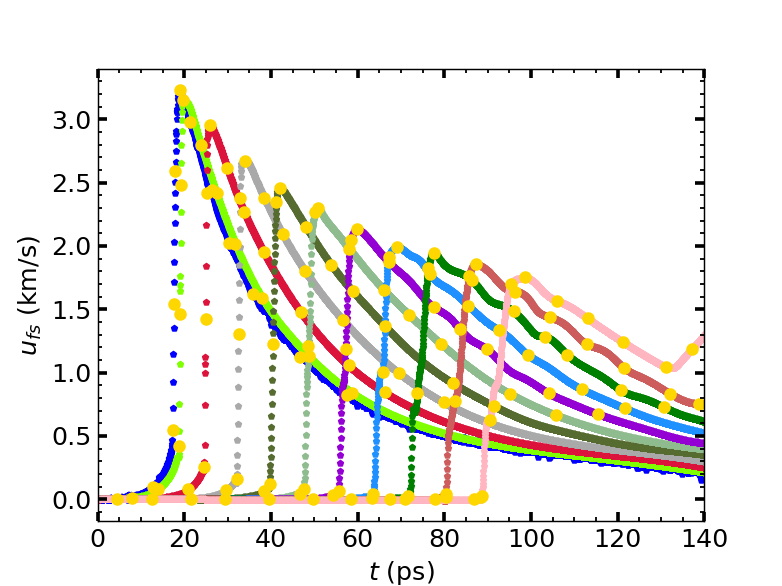

In [50]:
main_window = plt.figure(1)

<IPython.core.display.Javascript object>


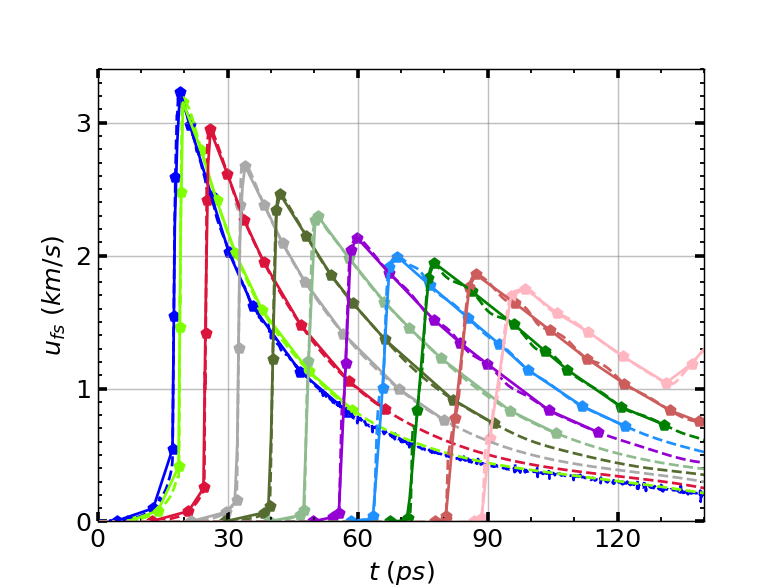

In [51]:
analasys_window = plt.figure(2)

<IPython.core.display.Javascript object>


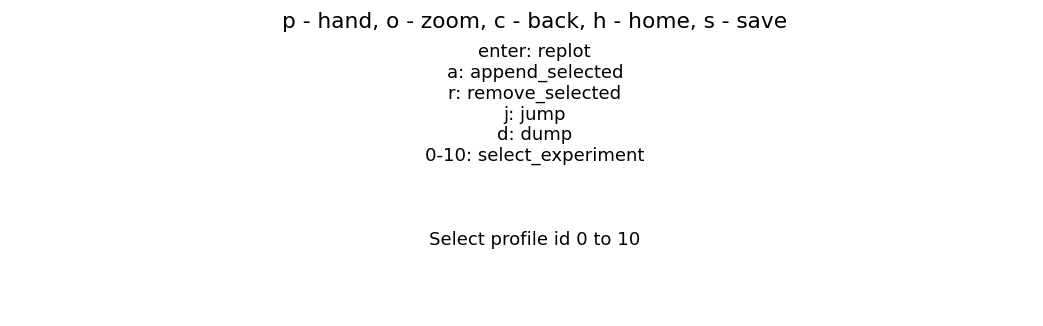

In [52]:
plt.rcParams["figure.figsize"] = (8,2.5)
message_window = plt.figure(3)
plt.rcParams["figure.figsize"] = (6,4.5)

In [53]:
# First subplot for showing of profiles
readed = main_window.add_subplot(111)

# Second subplot for selected points
selected_plot = analasys_window.add_subplot(111)

# Third subplot is for a messages and additional information
messages = message_window.add_subplot(111)

message_keyboard = messages.text(0.5,0.2,"", va="center", ha="center")
message_up = messages.text(0.5,0.7,"", va="center", ha="center")

messages.set_title('p - hand, o - zoom, c - back, h - home, s - save')
messages.axis("off")

(0.0, 1.0, 0.0, 1.0)

In [54]:
""" The set of interaction functions to provide 
following manipulations in matplotlib
- select individual points on the spline  approximation of experimental data
- remove selected points
- automatic check of the validity for a given set of selected points
"""

def replot(event):
# Clear the second subplot
    selected_plot.clear()
    j=0
    for width, t_ufs_selected in selected.items():
# Plot selected points in the axis ''
        if width==current_width:
# Plot pickable points    
            selected_plot.scatter(np.array(t_ufs_selected)[:,0],np.array(t_ufs_selected)[:,1], 
                         marker='o', s=35, color = colors[j])
        else:
# Plot other points    
            selected_plot.scatter(np.array(t_ufs_selected)[:,0],np.array(t_ufs_selected)[:,1], 
                         marker='p', s=35, color = colors[j])
            if width=="970":
                for i in range(len(np.array(t_ufs_selected)[:,0])):
                    x = np.array(t_ufs_selected)[i,0]
                    y = np.array(t_ufs_selected)[i,1]
                    if i==0 or i==2:
                        x -=  3
                    selected_plot.text(x,y+0.1,str(i+1), va="center", ha="center")
        j+=1

    i=0
    for width, t_ufs in grid_univ_spl_dict_ufs_t.items():
        selected_plot.plot(t_ufs[:,0],t_ufs[:,1], 
                         color=colors[i], linestyle='--')            
        i+=1
    selected_plot.set_xlabel("$t$ $(ps)$", **csfont)
    selected_plot.set_ylabel("$u_{fs}$ $(km/s)$", **csfont)
    selected_plot.set_ylim(-0.0,3.4)
    selected_plot.set_xlim(0,140)
    selected_plot.grid(color='grey', alpha=0.5)
    subplot_axes_ticks_tuning(selected_plot)
    selected_plot.yaxis.set_major_locator(MultipleLocator(1))
    selected_plot.yaxis.set_minor_locator(MultipleLocator(0.1))
    selected_plot.xaxis.set_major_locator(MultipleLocator(30))
    selected_plot.xaxis.set_minor_locator(MultipleLocator(10))

def sort_selected(event=1):
    global selected
    global current_width
    import copy
    indices = list(range(len(selected[current_width])))
    indices.sort(key = [item[0] for item in selected[current_width] ].__getitem__)
    copy_of_selected = copy.deepcopy(selected[current_width])
    selected[current_width] = [copy_of_selected[j] for j in indices]

def append_selected(event):
    global current_width
    global selected
    ind = event.ind

    selected[current_width].append([np.take(grid_univ_spl_dict_ufs_t[current_width][:,0],ind)[0],
                                 np.take(grid_univ_spl_dict_ufs_t[current_width][:,1],ind)[0],
                                   int(current_width)/1e3])
    sort_selected()
    my_str = current_width + " " +str(ind[0])+' '+\
      str(np.take(grid_univ_spl_dict_ufs_t[current_width][:,0],ind)[0])+' '+\
      str(np.take(grid_univ_spl_dict_ufs_t[current_width][:,1],ind)[0])
    message_keyboard.set_text(my_str)

def replot_readed():   
    global current_width
    readed.clear()
    i = 0
    for width, t_ufs in grid_univ_spl_dict_ufs_t.items():
# Plot selected points in the axis ''
        if width==current_width:
# Plot pickable points
            readed.scatter(t_ufs[:,0],t_ufs[:,1], 
                          marker='o', s=20, picker = True, color = colors[i])
        else:
# Plot other points    
            readed.scatter(t_ufs[:,0],t_ufs[:,1], 
                         marker='p', s=10, color = colors[i])

        i+=1
    if replot_readed_draw_selected:
        j=0
        for width, t_ufs_selected in selected.items():
    # Plot selected points in the axis ''
            if t_ufs_selected!=[]:
                readed.scatter(np.array(t_ufs_selected)[:,0],np.array(t_ufs_selected)[:,1], 
                             marker='o', s=35, color = "gold")
                j+=1
    if raw_INA:
        dataINA = np.genfromtxt(Path("Ashitkov/data/160_t_uINA.dat"), delimiter="\t")
        mask = np.isnan(dataINA[:,1])
        raw_160 = dataINA[~mask]
        readed.plot(raw_160[400:680,0], raw_160[400:680,1], color = "grey", linestyle ="--")

    readed.set_xlabel("$t$ (ps)", **csfont)
    readed.set_ylabel("$u_{fs}$ (km/s)", **csfont)
    readed.set_xlim(0,140)
    subplot_axes_ticks_tuning(readed)

    # Includes to picker and remove event a chosen experiment
def select_experiment(event):
    global current_width
    current_width = experiment_id[event.key]
    message_keyboard.set_text("Selected width "+current_width)
    replot_readed()

# Removes the last point appended to the selected for the current_width
def remove_selected(event):
    global current_width
    global selected
    selected[current_width].pop()
    message_keyboard.set_text("Removed from "+current_width)

# Searches for jumps in profiles to account them in antiderivatives 
def jump(event = 1):
    global selected
    mystr = ""
    for width, t_ufs_selected in selected.items():
        t_ufs_numpy_temp = np.array(t_ufs_selected)
        if len(selected[width][-1])>3:
            (selected[width][-1])[3] = 0
        else:
            selected[width][-1].append(0)
        for i in range(len(t_ufs_selected)-1):
            delta = ((selected[width][i+1])[1]-(selected[width][i])[1])#/\
            if delta>delta_jump:
                if len(selected[width][i])>3:
                    (selected[width][i])[3] = delta
                else:
                    selected[width][i].append(delta)
            else:
                if len(selected[width][i])>3:
                    (selected[width][i])[3] = 0
                else:
                    selected[width][i].append(0)
        mystr += str(len(t_ufs_selected)) + " "
    message_keyboard.set_text(mystr)
    

def save_dump(to_save):
    import json
    for width, t_ufs_selected in selected.items():
        if len(t_ufs_selected)<4:
            jump()
    with open(Path(work_dir+data_folder+"/reference_points.json"), "w") as outfile:
        json.dump(to_save, outfile) 

def dump(event):
    my_str = "saved "
    for_dump = {}
    for i in selected.keys():
        if selected[i]!=[]:
            for_dump[i] = list(selected[i])
            my_str += i+" "
    message_keyboard.set_text(my_str)
    save_dump(for_dump)


In [55]:
import json
for_dump = {}
for width, t_ufs_selected in selected.items():
    for item in t_ufs_selected:
        if len(item)<4:
            jump()
for i in selected.keys():
    for_dump[i] = list(selected[i])

with open(Path(work_dir+data_folder+"/reference_points.json"), "w") as outfile:
    json.dump(for_dump, outfile)

In [56]:
# Clear the first axes
readed.clear()

# Temporary lists for colors
c = list(colors)
usc = list(colors)
i=0
for width, t_ufs in dict_ufs_t.items():
    i += 1
    print(i)
# Plot readed profiles in the axis 'readed'
    readed.plot(t_ufs[:,0],t_ufs[:,1], color = colors[i], label=width)
    readed.legend()
# Plot shown data approximated with univariate splines with a high stiffnes
#    readed.plot(t_ufs[:,0], univ_spl_dict_ufs_t[width](t_ufs[:,0]),usc.pop()[0]+"+")

if raw_INA:
    dataINA = np.genfromtxt(Path("Ashitkov/data/160_t_uINA.dat"), delimiter="\t")
    mask = np.isnan(dataINA[:,1])
    raw_160 = dataINA[~mask]
    readed.plot(raw_160[400:680,0], raw_160[400:680,1], color = "grey", linestyle ="--")
    readed.set_xlabel("$t$ $(ps)$", **csfont)
    readed.set_ylabel("$u_{fs}$ $(km/s)$", **csfont)
    readed.set_ylim(-0.02,3.02)
    readed.set_xlim(2,250)
    readed.grid(color='grey', alpha=0.5)

1
2
3
4
5
6
7
8
9
10
11


In [57]:
# Create N-times finer grid of data approximated with univariate splines with a high stiffnes 
N = 1

for width, t_ufs in dict_ufs_t.items():
    grid_t = np.linspace( t_ufs[0,0], t_ufs[-1,0], N*len(t_ufs[:,0]) )
    grid_univ_spl_dict_ufs_t.setdefault(width, np.vstack( (grid_t[:],
                            univ_spl_dict_ufs_t[width](grid_t[:])) ).T )
    i += 1

replot_readed()

In [58]:
""" Events are connecting to the canvas "fig"
gets the functionality dictionary
"""
class InteractionEngine:
    def __init__(self, fig, dispatch):
        self.cid_keyboard = fig.canvas.mpl_connect('key_press_event', self.key_pressed)
        self.cid_pick = fig.canvas.mpl_connect('pick_event', append_selected)
        self.dispatch = dispatch

    def key_pressed(self, event):
        if event.key=='A':
            event.key='10'
        tx = "key=%s" %(event.key)
        message_keyboard.set_text(tx)
        self.dispatch[event.key](event)

    def detouch_exit(self):
        fig.canvas.mpl_disconnect(cid_keyboard)
        fig.canvas.mpl_disconnect(cid_pick)
        messages.set_title("closed")    


In [59]:
# Load functions for interactions with graphs

dispatch = {
    "enter":replot,
    "a"    :append_selected,
    "r"    :remove_selected,
    "j"    :jump,
    "d"    :dump,
    "0-"+str(len(grid_univ_spl_dict_ufs_t.keys())-1)  :select_experiment
}
# Create interactive engine to call defined functions
in_en = InteractionEngine(main_window, dispatch)

def get_experiments_ids(dictionary_of_names):
    my_str = ""
    for key,value in dictionary_of_names.items():
        my_str += key+": "+str(value.__name__)+"\n"
    return my_str

message_up.set_text(get_experiments_ids(dispatch))
dispatch.popitem()
for key,value in experiment_id.items():
    dispatch.setdefault(key,select_experiment)
message_keyboard.set_text("Select profile id 0 to "+str(len(grid_univ_spl_dict_ufs_t.keys())-1))


if out_selected:
    selected

In [60]:
### A window with functions $u_i(h)$ and $t_i(h)$
# Constrution of 2D arrays velocity, width(Lagrandion coordinate) and time for computations  
t_range, h_range = [], []

uij_h_const, hij_h_const, tij_h_const, duij_h_const = [], [], [], []

duij, uij, hij, tij = [], [], [], []
for key, ufs_t_h_for_given_h in selected.items():
    for ufs_t_h in ufs_t_h_for_given_h:
        tij_h_const.append(ufs_t_h[0])
        uij_h_const.append(ufs_t_h[1])
        hij_h_const.append(ufs_t_h[2])
        duij_h_const.append(ufs_t_h[3])
    uij.append(uij_h_const)
    hij.append(hij_h_const)
    tij.append(tij_h_const)
    duij.append(duij_h_const)
duij = np.array(duij)
uij = np.array(uij)
hij = np.array(hij)
tij = np.array(tij)
NRP_t = len(selected[list(selected.keys())[0]])
print(NRP_t)
NRP_h = len(selected)
print(NRP_h)
# Arrays are indexed in such a way
# uij[0,i::NRP_t][j] where
# i - index for t
# j - for h
# It is difficult to associate the array with two-dimensional grid,
# because for each h we obtained a series of different time moments of fixed length


12
11


In [61]:
## This a set of arrays to fit procedures and procedures for integration of interpolated function $u(h,t)$
# Method returns interpolation coefficients 
# which will be used for antiderivatives calculation 
up_fit, upt_fit, t_fit, h_fit = [], [], [], []
fit_range = [0,1,2,3,4,5,6,7,8,9,10]


class PolyChain:
    def __init__(self,x,y):
        self.qubic    = UnivariateSpline(x,y,k=3,s=0,ext=3)
    def __call__(self, x):
        return self.qubic(x)
    
def fit_spline(x,y):
    return UnivariateSpline(x,y,k=1, s=0, ext=3)

def fit_poly(x,y,n):
    return np.poly1d(np.polyfit(x, y, n))

def fit_poly_or_spline(fit_key, x,y):
    if isinstance(fit_key, int) and fit_key<len(x):
        return fit_poly(x,y,fit_key)
    else:
        return fit_spline(x,y)

fit_key_t = "spline"
fit_key_u = "spline"
#for i in range(NRP_t):
#    tij[0,i::NRP_t][0] -= 1
#print(tij[0,NRP_t-1::NRP_t][0])
#print(tij[0,0::NRP_t][0])
#t0 =(tij[0,NRP_t-1::NRP_t][0]+tij[0,0::NRP_t][0])/2
t0 =tij[0,0::NRP_t][0]
#print(t0)
for i in range(NRP_t):
    tij[0,i::NRP_t][1] = tij[0,i::NRP_t][1]#+2.5#0.23*(tij[0,i::NRP_t][0]-t0)+2.3
    #print(tij[0,i::NRP_t][0])
#    uij[0,i::NRP_t][0] = 0.8*uij[0,i::NRP_t][0]
for i in range(NRP_t):
    #print(i)
    #print(hij[0,i::NRP_t][fit_range])
#     fit = fit_poly_or_spline(fit_key_t, hij[0,i::NRP_t][fit_range],uij[0,i::NRP_t][fit_range])
    fit = PolyChain(hij[0,i::NRP_t][fit_range],uij[0,i::NRP_t][fit_range])
    up_fit.append(fit)

    fit = fit_poly_or_spline(fit_key_u, hij[0,i::NRP_t][fit_range], tij[0,i::NRP_t][fit_range])
    t_fit.append(fit)
    fit = fit_poly_or_spline(fit_key_t, tij[0,i::NRP_t][fit_range], hij[0,i::NRP_t][fit_range])
    h_fit.append(fit)

    fit = fit_poly_or_spline(fit_key_t, tij[0,i::NRP_t][fit_range],uij[0,i::NRP_t][fit_range])
    upt_fit.append(fit)
    # Additional array for smooth plot of the fit
h_for_fit = np.linspace(hij[0,0::NRP_t][0]-0.01,hij[0,0::NRP_t][NRP_h-1]+0.01, 100)

#print(hij[0,0::NRP_t])
#print(hij[0,NRP_t-1::NRP_t])
#print(hij[0,0::NRP_t][0])
#print(hij[0,0::NRP_t][1])
#print(hij)
#0

In [62]:
# A set of functions to make an interaface for fit of profiles with different width.

def ti(h, i):
    return t_fit[i](h)

def hi(t, i):
    return h_fit[i](t)

def dtdhi(h, i):
    return t_fit[i].derivative()(h)

def dhdti(t, i):
    return h_fit[i].derivative()(t)
    

def uip(h, i):
    return up_fit[i](h) 

def dupdhi(h, i):
    return up_fit[i].derivative()(h) 

def dupdti(t, i):
    return upt_fit[i].derivative()(t)

def u_h_t(h, t, i):
    if i==NRP_t-1:
        return uip(h,i)
    else:
        return (uip(h,i)*(ti(h,i+1)-t)+\
     uip(h,i+1)*(t-ti(h,i)) )/ \
     (ti(h,i+1)-ti(h,i))

<IPython.core.display.Javascript object>


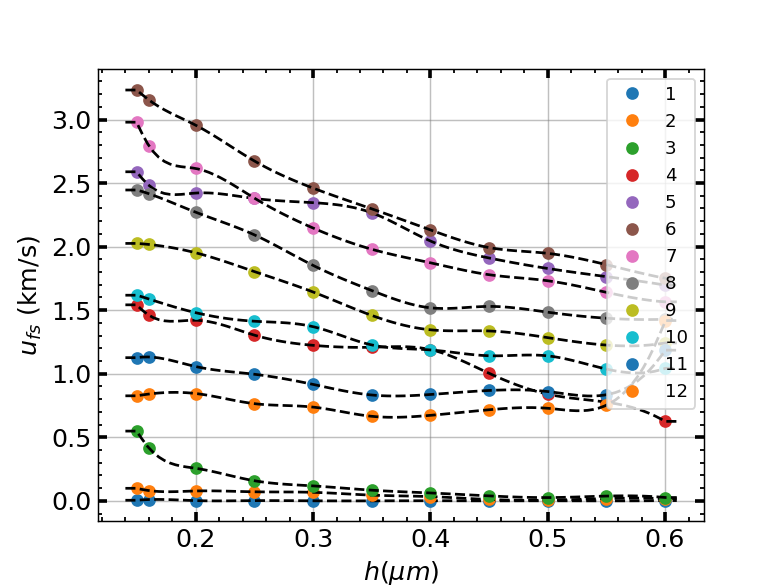

In [63]:
fit_u_window = plt.figure(4)
u_h_window = fit_u_window.add_subplot(111)


In [64]:
u_h_window.clear()
for i in range(NRP_t):
    u_h_window.plot(hij[0,i::NRP_t],uij[0,i::NRP_t], 'o', label = str(i+1))
    ui_fit_of_h = uip(h_for_fit,i)
    u_h_window.plot(h_for_fit,ui_fit_of_h , 'k--')
u_h_window.set_xlabel(r"$h (\mu m)$", **csfont)
u_h_window.set_ylabel("$u_{fs}$ (km/s)", **csfont)
u_h_window.legend()
u_h_window.grid(color='grey', alpha=0.5)
subplot_axes_ticks_tuning(u_h_window)
if savefigures:
    fit_u_window.savefig(Path(work_dir+figures_folder+"/uh.pdf"), dpi=300, format='pdf')

In [65]:
# Complete function u(h,t)
def u(h,t):
    time_i = []
    for j in range(NRP_t):    #Number of time intervals where piecewise function defined.
        time_i.append(ti(h, j))
    if t<time_i[0]:
        return -0.01
    else:
        if t>time_i[-1]:
            return -0.01
        else:
            for k in range(NRP_t-1):
                if t>=time_i[k] and \
                   t<time_i[k+1]:
                    return u_h_t(h, t, k)


<IPython.core.display.Javascript object>


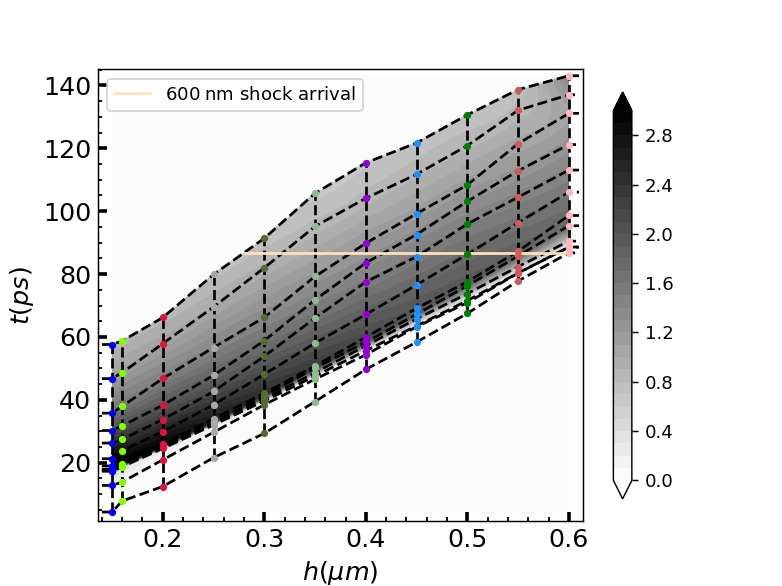

In [66]:
fit_t_window = plt.figure(5)

In [67]:
fit_t_window.clear()
t_h_window = fit_t_window.add_subplot(111)
print(t_h_window)


for i in range(NRP_t):
    ti_fit_of_h = ti(h_for_fit,i)
    t_h_window.plot(h_for_fit,ti_fit_of_h, 'k--')

for h in np.linspace(min(hij[0,0::NRP_t]), max(hij[0,::NRP_t]), 200):
    if h>hi(ti(max(hij[0,::NRP_t]),0),NRP_t-1):
        hmin = h
        break

t_h_window.plot(np.linspace(hmin, max(hij[0,::NRP_t]), 100),tij[0,0::NRP_t][-1]*np.ones(100), 
                color ='moccasin',
                linestyle = '-',
                label=r"600$\;$nm shock arrival")

for j in range(NRP_h):
    t_h_window.vlines(x = hij[0,0::NRP_t][j],
                      ymin = tij[0,0::NRP_t][j],
                      ymax = tij[0,NRP_t-1::NRP_t][j], 
                      linestyle = '--',
                      color = 'k')
t_h_window.legend()
t_h_window.set_xlabel(r"$h (\mu m)$", **csfont)
t_h_window.set_ylabel("$t (ps$)", **csfont)



# Add same 2d cotour features to the window with t_h
h_contour, t_contour = np.meshgrid(np.linspace(width_indexed[0], width_indexed[NRP_h-1], 200),
                        np.linspace(tij[0,0::NRP_t][0],tij[0,NRP_t-1::NRP_t][NRP_h-1], 200) )
u_contour = np.zeros((len(h_contour[:,0]),len(h_contour[0,:])))
print(type(u(h_contour[0,0],t_contour[0,0])))
eps=1e-5
for i in range(len(h_contour[:,0])):
    for j in range(len(h_contour[0,:])):
        if (i!=199 or j!=199):
            u_contour[i,j] = max([u(h_contour[i,j],t_contour[i,j]),eps]) 
        else:
            u_contour[i,j] = eps
        
cs = t_h_window.contourf(h_contour, t_contour, u_contour,
                levels=list(np.linspace(0,3.,31)),
                cmap = 'binary', 
                extend = 'both',
                vmin = eps,
                vmax = 3.0)
      
for i in range(NRP_t):
    for j in range(NRP_h):
        t_h_window.plot(hij[0,i::NRP_t][j],tij[0,i::NRP_t][j],
                        color = colors[j],
                        linestyle = '',
                        marker = 'o',
                        markersize = 3)
        
t_h_window.set_xlim((width_indexed[0]-0.014,width_indexed[NRP_h-1]+0.014))
t_h_window.set_ylim((tij[0,0::NRP_t][0]-3,tij[0,NRP_t-1::NRP_t][NRP_h-1]+2))
subplot_axes_ticks_tuning(t_h_window)


fit_t_window.colorbar(cs,  shrink=0.9)


AxesSubplot(0.125,0.11;0.775x0.77)
<class 'numpy.float64'>


In [68]:
# Plot fitted function u(h,t)
replot(1)
k=0
for j in range(NRP_h):
    
    time = np.linspace(tij[0,0::NRP_t][j],
                       tij[0,NRP_t-1::NRP_t][j], 100)
    velocities = []
    for i in range(len(time)):
        velocities.append(u((hij[0,0::NRP_t])[j],time[i]))
    selected_plot.plot(time,velocities,color = colors[k])
    k+=1
    if variation:
        if j==0:
            selected_plot.plot(time+2.5,velocities, linestyle = "--", color = "grey")
            selected_plot.plot(time-2.5,velocities, linestyle = "--", color = "grey")



In [69]:
print(u(0.47, 100))

1.2285126286182604


In [70]:
def finite_difference(up, um, delta):
    return (up-um)/delta

"""Get a derivative we need finite difference u
 therefore u dependent on h and t function is needed
 where the region of coefficients fitting is automaticaly identified.
"""
def dudt_h_t(h, t, dt):
    if t+dt>ti(h,NRP_t-1):
        tp = t
        tm = t-dt
        k=1
    else:
        if t-dt<ti(h,0):
            tm = t
            tp = t+dt
            k=1
        else:
            tm = t-dt
            tp = t+dt
            k=0.5
    utp = u(h,tp)
    utm = u(h,tm)
    if utp<0 and utm!=0 or\
       utm<0 and utp!=0:
        return 0
    else:
        return k*finite_difference(utp,utm,dt)

"""Get a derivative we need finite difference u
 therefore u dependent on h and t function is needed
 where the region of coefficients fitting is automaticaly identified.
"""

def dudh_h_t(t, h, dh):
    if h+dh>hij[0,0::NRP_t][-1]:
        hp = h
        hm = h-dh
        k=1
    else: 
        if h-dh<hij[0,0::NRP_t][0]:
            hm = h
            hp = h+dh
            k=1
        else:
            hp = h+dh
            hm = h-dh
            k=0.5
    uhp = u(hp,t)
    uhm = u(hm,t)
    if (uhp<0 and uhm!=0) or \
       (uhm<0 and uhp!=0):
        return 0
    else:
        return k*finite_difference(uhp, uhm, dh)

def dudh_h_t2nd(t, h, dh):
    uhp = u(h+dh,t)
    u2hp = u(h+2*dh,t)
    uhm = u(h-dh,t)
    u2hm = u(h-2*dh,t)
    if uhp==0 and uhm!=0:
        uhp=u(h,t)
        if uhp==0:
            return 0
        else:
            return (-uhp+4*uhm-3*u2hm)/dh
    else:
        if uhm==0 and uhp!=0:
            uhm=u(h,t)
            if uhm==0:
                return 0
            else:
                return (3*u2hp-4*uhp+uhm)/dh
        else:
            return (u2hm-6*uhm+3*u(h,t)+2*uhp)/6/dh



In [71]:
"""We make a profile for chosen h and get values of deformation.
 Lets define the start and the end of time integration interval.
 Set up the grid in the time domain of interest and 
 make a differentiation and integration of u(h,t). 
 Calculate u on h derivative and u_h definite quadrature on t from 
 first piecewise linear ti(width,0) to the last piecewise linear ti(width,NRP_h-1)
"""
def epsilon_from_u_h_t(width):
    Nt = 600
    time_start = ti(width, 0)
    time_end = np.min([ti(width, NRP_t-1), ti(hij[0,0::NRP_t][-1], 0)])
    time_grid = np.linspace(time_start, time_end, Nt)
    epsilon = []
    deltah = (hij[0,0::NRP_t][-1]-hij[0,0::NRP_t][0])/300
    for i in range(len(time_grid)):
        epsilon.append( quad (dudh_h_t, time_start, time_grid[i],
                              args = (width,deltah) )[0]  )                       
    epsilon = np.array(epsilon)
    return epsilon, time_grid

"""We make a profile for chosen h and get the values of normal stress 
 along the time series for that value of h.
 Lets define the start of time integration
 and make a differentiation and integration of u(h,t) 
 by setting up the grid in the time domain of interest and 
 calculate the h boundary, where sigma==0 for each moment of time in the time grid.
 Now we have all the regions to calculate appropriate 
 u temporal derivative and u_t definite quadrature on h from h_bound_grid to chosen width  
"""
def sigma_from_u_h_t(width):
    Nt = 600
    time_start = ti(width, 0)
    time_end = np.min([ti(width, NRP_t-1), ti(hij[0,0::NRP_t][-1], 0)])
    time_grid = np.linspace(time_start, time_end, Nt)
    deltat = (time_end-time_start)/Nt
    h_bound_grid = hi(time_grid[-1], 0)

    sigma = []
    for i in range(len(time_grid)):
        sigma.append( quad (dudt_h_t, h_bound_grid, width,
                             args = (time_grid[i],deltat) )[0]  )                       
    sigma = np.array(sigma)
    return sigma, time_grid



In [72]:
"""This version makes calculation for reference points only,
because it's easier in calculation with taking into account jumps in the functions.
"""
def few_epsilon_from_u_h_t(j):
    width = (hij[0,0::NRP_t])[j]
    time_start = ti(width, 0)
    time_end = np.min([ti(hij[0,0::NRP_t][-1], 0)])
    time_grid = [time_start]
    for k in range(1,NRP_t):
        time = ti(width, k)
        if time<time_end:
            time_grid.append(time)
        else:
            time_grid.append(time_end)
            break
    deltah = (hij[0,0::NRP_t][-1]-hij[0,0::NRP_t][0])/300
    epsilon = []
    for time in time_grid:
        epsilon.append( quad (dudh_h_t, time_start, time,
                              args = (width,deltah), limit=200 )[0])
        print("epsilon: "+str(width)+" "+str(time)+" "+str(1+epsilon[-1]/2e3))
    epsilon = np.array(epsilon)
    time_grid = np.array(time_grid)
    return epsilon, time_grid

def few_sigma_from_u_h_t(j):
    width = (hij[0,0::NRP_t])[j]
    time_start = ti(width, 0)
    time_end = np.min([ti(hij[0,0::NRP_t][-1], 0)])
    time_grid = [time_start]
    for k in range(1,NRP_t):
        time = ti(width, k)
        if time<time_end:
            time_grid.append(time)
        else:
            time_grid.append(time_end)
            break
    deltat = (time_end-time_start)/600
    width_bound = hi(time_grid[-1], 0)
    sigma = []
    for time in time_grid:
        sigma.append( quad (dudt_h_t, width_bound, width,
                             args = (time,deltat), limit=200 )[0]  )  
        print("sigma: "+str(width)+" "+str(time)+" "+str(-7.874e3*sigma[-1]/2e0))

    sigma = np.array(sigma)
    time_grid = np.array(time_grid)
    return sigma, time_grid

In [73]:
"""This version makes calculation for reference points only,
because it's easier in calculation with taking into account jumps in the functions.
"""
def few_shock_epsilon_from_u_h_t(j):
    width = (hij[0,0::NRP_t])[j]
    time_end = ti(hij[0,0::NRP_t][-1], 0)
    time_grid = []
    i_end = 0
    for i in range(0,NRP_t):
        time = ti(width, i)
        #print(str(width)+" "+str(time))
        if time<time_end:
            time_grid.append(time)
        else:
            i_end = i-1
            break
    deltah = (hij[0,0::NRP_t][-1]-hij[0,0::NRP_t][0])/300
    epsilon = [0]
    current_time = time_grid[0]
    sum_epsilon = 0
    for i in range(np.max([len(time_grid)-1,i_end-1])):
        local_end_time = time_grid[i+1]
        delta_u = (selected[str(int(1000*width))][i])[3]
        if delta_u > 0:
            sum_epsilon -= delta_u * dtdhi(width, i+1) - dupdhi(width, i+1) * (local_end_time - current_time) 
        else:
            sum_epsilon += quad (dudh_h_t, current_time, local_end_time,
                      args = (width,deltah), limit = 200 )[0]
        current_time = local_end_time
        print("epsilon: "+str(width)+" "+str(i)+" "+str(1+sum_epsilon/2e3))
        epsilon.append(sum_epsilon)                       
    epsilon = np.array(epsilon)
    time_grid = np.array(time_grid)
    return epsilon, time_grid

def distance(h,width, k):
    return np.sqrt(1+dtdhi(width, k)**2)

def few_shock_sigma_from_u_h_t(j):
    width = (hij[0,0::NRP_t])[j]
    time_start = ti(width, 0)
    time_end = ti(hij[0,0::NRP_t][-1], 0)
    time_grid = []
    i_end = 0
    for i in range(0,NRP_t):
        time = ti(width, i)
        if time<time_end:
            time_grid.append(time)
        else:
            i_end = i-1
            break
    deltat = (time_end-time_start)/300
    sigma = [0]
    for i in range(1,np.max([len(time_grid),i_end])):
        sum_sigma = 0
        time = time_grid[i]
        current_width = hi(time,0)
        # let's go through the ti(current width) for each
        for k in range(0,i):
            local_end_width = hi(time, k+1)
            # first of all calculate the value of delta_u
            l_h = 0
            for l in range(NRP_h-1):
                h1 = hij[0,0::NRP_t][l]
                h2 = hij[0,0::NRP_t][l+1]
                if h1<=local_end_width and \
                   h2>local_end_width:
                    l_h = l
            l1 = quad(distance,h1,local_end_width, args = (local_end_width,l_h))[0]
            if l1>0:
                l1 = 1/l1
            else:
                l1 = 1
                l2 = 0
            l2 = quad(distance,local_end_width,h2,args = (local_end_width,l_h+1))[0]
            if l2>0:
                l2 = 1/l2
            else:
                l2 = 1
                l1 = 0
            delta_u = ((selected[str(int(1000*h1))][k])[3]*l1+
                       (selected[str(int(1000*h2))][k])[3]*l2)/(l1+l2)
            if delta_u > 0:
                sum_sigma += dupdti(time,k) * (local_end_width - current_width) \
                                            - delta_u * (dhdti(time, k)+dhdti(time, k+1))/2
            else:
                sum_sigma += quad (dudt_h_t, current_width, local_end_width,
                         args = (time,deltat), limit = 200  )[0]
            current_width = local_end_width
        print("sigma: "+str(width)+" "+str(i)+" "+str(-7.874e3*sum_sigma/2e0))
        sigma.append(sum_sigma)
    sigma = np.array(sigma)
    time_grid = np.array(time_grid)
    return sigma, time_grid

In [74]:
def path_integrator(name, j):
    if name[0:3]=="few":
        return eval(name+"_from_u_h_t("+str(j)+")")
    return eval(name+"_from_u_h_t((hij[0,0::NRP_t])["+str(j)+"])")

In [75]:
"""Calculate if needed arrays of 
sigma(t) for each h
and epsilon, which is converted to v_over_v0
"""
if calc_sigma_epsilon:
    for j in [1,2,3,4,5,6,7,8]:
        sigma, time_grid_sigma = path_integrator(prefix+"sigma", j)
        sigma = -7.874e3*sigma/2e0
        end = ".csv"
        savetxt(Path(work_dir+results_folder+"/sigma_with_splines_"+str(j)+end),
                                         sigma, delimiter = ',')

        epsilon, time_grid_epsilon = path_integrator(prefix+"epsilon", j)
        epsilon = epsilon/2e3
        v_over_v0 = 1+epsilon
        print(sigma)
        print(v_over_v0)
        savetxt(Path(work_dir+results_folder+"/epsilon_with_splines_"+str(j)+end),
                                        v_over_v0, delimiter = ',')
        savetxt(Path(work_dir+results_folder+"/time_grid_with_splines_"+str(j)+end),
                                          time_grid_epsilon, delimiter = ',')

In [76]:
# Read data and correct normal stress 
results_path = Path(work_dir+results_folder)

def unpack_sheet(sheet):
    data = np.genfromtxt(sheet, delimiter=",")
    return data[~np.isnan(data)]

def read_sheets(where):
    return [unpack_sheet(sheet) for sheet in 
            sorted( list( results_path.glob(where+"_*.csv") ),
            key = lambda i:int( os.path.basename(i).split('.')[0].split('_')[-1][:] ) ) ]

sigma = read_sheets("sigma")
v_over_v0 = read_sheets("epsilon")
timegrid_epsilon = read_sheets("time_grid")



<IPython.core.display.Javascript object>


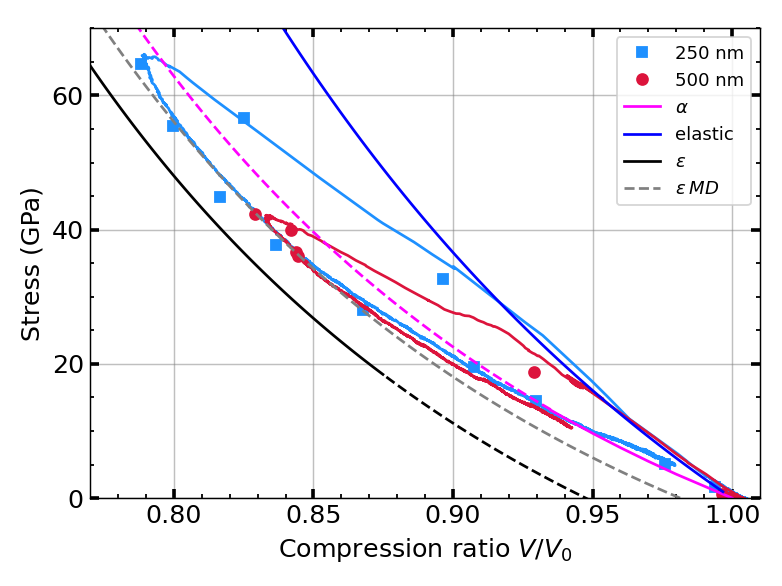

In [77]:
fit_sigma_window = plt.figure(6)
sigma_v_ver_v0_window = fit_sigma_window.add_subplot(111)

In [78]:
print(sigma[3])
print(timegrid_epsilon[3])
print(sigma[8])
print(timegrid_epsilon[8])

[ 0.          1.62715636  5.00901014 32.57932106 56.6855124  64.66763941
 55.44838052 44.9327661  37.77672741 28.08174303 19.4994045  14.48287711]
[21.5997219  29.66361808 32.01558779 32.49558161 32.87957667 33.98356246
 38.3995056  42.6714506  47.80738447 56.63927076 69.55110452 79.87097165]
[ 0.          0.13383976  0.64482194 18.78813568 39.98852954 42.32409483
 36.61826687 36.1119673 ]
[67.48713109 70.89508721 71.56707856 73.77505013 76.31901738 77.56700131
 86.30288884 86.73488327]


In [79]:
sigma_v_ver_v0_window.clear()
N = None
plot_range= [3,8]
i_variation = 11
for i in plot_range:
    if i<i_variation:
        filename = str(i)+"_"+str(1000*width_indexed[i])+".dat"
        myfile = open(work_dir+xfolder+"/"+filename, "w")
        myfile.close()
    else:
        filename = str(i)+"_160m.dat"
        myfile = open(work_dir+xfolder+"/"+filename, "w")
        myfile.close()
        filename = str(i)+"_160p.dat"
        myfile = open(work_dir+xfolder+"/"+filename, "w")
        myfile.close()
    Nt = 100
    if i<i_variation:
        width = width_indexed[i]
    else:
        width = width_indexed[0]
    time_start = ti(width, 0)
    time_end = np.min([ti(width, NRP_t-1), ti(hij[0,0::NRP_t][-1], 0)])

    deltat = (time_end-time_start)/Nt
    for j in range(len(timegrid_epsilon[i])):
        timegrid_value = timegrid_epsilon[i][j]
        for k in range(NRP_t):
            if i<i_variation:
                if abs(tij[0,k+(NRP_t)*i]-timegrid_value)<deltat/2:
        #                print("succeed: "+str(tij[0][k+NRP_t*i]))
#                     sigma_v_ver_v0_window.scatter(v_over_v0[i][j], sigma[i][j],
#                                                   marker='p',
#                                                   s=55,
#                                                   color = 'black')
                    filename = str(i)+"_"+str(1000*width_indexed[i])+".dat"
                    myfile = open(work_dir+xfolder+"/"+filename, "a")
                    myfile.write(str(v_over_v0[i][j])+" "+
                                 str(sigma[i][j])+" "+
                                 str(timegrid_value)+"\n")
                    myfile.close()
            else:
#                if abs(tij[0,k]-timegrid_value)<deltat/2:
                sigma_v_ver_v0_window.scatter(v_over_v0[i][j], sigma[i][j],
                                              marker='p',
                                              s=25,
                                              color = 'grey')
                if i==i_variation:
                    filename = str(i)+"_160m.dat"
                    myfile = open(work_dir+xfolder+"/"+filename, "a")
                    myfile.write(str(v_over_v0[i][j])+" "+
                                 str(sigma[i][j])+" "+
                                 str(timegrid_value)+"\n")
                    myfile.close()
                    if k==5 and j == 5:
                        sigma_v_ver_v0_window.text(v_over_v0[i][j]-0.0025,sigma[i][j]+1.2,
                                                   "-2.5",
                                                   va="center",
                                                   ha="center",
                                                   **csfont)
                if i==i_variation+1:
                    filename = str(i)+"_160p.dat"
                    myfile = open(work_dir+xfolder+"/"+filename, "a")
                    myfile.write(str(v_over_v0[i][j])+" "+
                                 str(sigma[i][j])+" "+
                                 str(timegrid_value)+"\n")
                    myfile.close()
                    if k ==5 and j == 5:
                        sigma_v_ver_v0_window.text(v_over_v0[i][j],sigma[i][j]+1.2,
                                                   "+2.5",
                                                   va="center",
                                                   ha="center",
                                                   **csfont)

#                if abs(tij[0,k+(NRP_t)*i]-timegrid_value)<deltat/2:
#        #                print("succeed: "+str(tij[0][k+NRP_t*i]))
#                    sigma_v_ver_v0_window.scatter(v_over_v0[i][j], sigma[i][j],
#                                                marker='p', s=35, color = 'black')
#            else:
#                if abs(tij[0,k]-timegrid_value)<deltat/2:
#                    sigma_v_ver_v0_window.scatter(v_over_v0[i][j], sigma[i][j],
#                                                 marker='p', s=25, color = 'grey')
#                    if k==6 and i==4:
#                        sigma_v_ver_v0_window.text(v_over_v0[i][j],sigma[i][j]+2,
#                                         "-2.5", va="center", ha="center", **csfont)
#                    if i==5 and k ==5:
#                        sigma_v_ver_v0_window.text(v_over_v0[i][j],sigma[i][j]+1.2,
#                                         "+2.5", va="center", ha="center", **csfont)
#
                    
                    

#range(1,NRP_h-2)
for i in plot_range:
    print(v_over_v0[i][:N])
    print(sigma[i][:N])
    if i == 3:
        marker_id = 's'
    else:
        marker_id = 'o'
    sigma_v_ver_v0_window.plot(v_over_v0[i][:N], sigma[i][:N], 
                            label = str(int(1000*width_indexed[i]))+" nm", 
                            color = colors[NRP_h-i-1],
                            linestyle="",
                            marker=marker_id)
    sigma_v_ver_v0_window.plot((7.9/dict_P_rho_t[str(int(1000*width_indexed[i]))])[:,2], 
                               (dict_P_rho_t[str(int(1000*width_indexed[i]))])[:,1],
                               linestyle="-",
                               color = colors[NRP_h-i-1])

    np.savetxt(work_dir+xfolder+"/r_"+str(i)+"_"+str(1000*width_indexed[i])+".dat", 
               np.asarray([v_over_v0[i][:N], sigma[i][:N], timegrid_epsilon[i][:N]]).T,
                comments = "v/v0, sigma, time")
K = None #35
L = None # 52
if variation:
    sigma_v_ver_v0_window.plot(v_over_v0[i_variation][:K], sigma[i_variation][:K],
                               linestyle = "--", color = "grey")
    np.savetxt(work_dir+xfolder+"/r_160m.dat", 
                   np.asarray([v_over_v0[i_variation][:K], sigma[i_variation][:K],
                    timegrid_epsilon[i_variation][:K]]).T,
                    comments = "v/v0, sigma, time")

    sigma_v_ver_v0_window.plot(v_over_v0[i_variation+1][:L], sigma[i_variation+1][:L],
                            linestyle = "--", color = "grey")
    np.savetxt(work_dir+xfolder+"/r_160p.dat", 
                   np.asarray([v_over_v0[i_variation+1][:L], sigma[i_variation+1][:L],
                               timegrid_epsilon[i_variation+1][:L]]).T,
                               comments = "v/v0, sigma, time")
def shock_Hugoniot(rho,rho0,ca,sa):
    return rho0*ca**2*(1-rho0/rho)/(1-sa*(1-rho0/rho))**2
if sigma_ZVV:
    Hugoniot_ZVV = pd.read_csv(Path(os.path.join(work_dir,data_folder,"Fe-100-Hugoniot.dat")),
                                  sep='\s+', engine='python')
    #sigma_v_ver_v0_window.plot(Hugoniot_ZVV["V/V0"], Hugoniot_ZVV["P11[GPa]"],
    #                                       color = "b",marker="o",linestyle="")
#     Hugoniot_experiment = pd.read_csv(Path('Ashitkov/data/Hugoniot_exp.dat'),
#                                   sep=',', engine='python')
#     sigma_v_ver_v0_window.plot(Hugoniot_experiment["V/V_0"], Hugoniot_experiment["P"],
#                                            color = "k",marker="p",linestyle="")
    Hugoniot_experiment = pd.read_csv(Path(os.path.join(work_dir,data_folder,"shock_hugoniots_fe.dat")),
                                                                            sep=',', engine='python')
    sigma_v_ver_v0_window.plot(Hugoniot_experiment["V/V0_as"],
                               Hugoniot_experiment["P_as"],
                               color = "magenta",linestyle="-", label = r"$\alpha$")
#     Hugoniot_experiment = pd.read_csv(Path('Ashitkov/data/Hugoniot_exp.dat'),
#                                   sep=',', engine='python')
#     sigma_v_ver_v0_window.plot(Hugoniot_experiment["V/V_0"], Hugoniot_experiment["P"],
#                                            color = "k",marker="p",linestyle="")

    rho0, ca, sa = 7.900, 4.6300, 1.33
    rho = np.linspace(7.900/0.935,10.500,100)

    p = shock_Hugoniot(rho,rho0,ca,sa)
    sigma_v_ver_v0_window.plot(rho0/rho,p,linestyle='--',color='magenta')
    #sigma_v_ver_v0_window.plot(Hugoniot_experiment["V/V0_am"],
    #                           Hugoniot_experiment["P_am"],
    #                           color = "orange",linestyle="--")
    #sigma_v_ver_v0_window.plot(Hugoniot_experiment["V/V0_es"],
    #                     Hugoniot_experiment["P_es"], color = "k",linestyle="-")
    #sigma_v_ver_v0_window.plot(Hugoniot_experiment["V/V0_em"],
    #                     Hugoniot_experiment["P_em"], color = "k",linestyle="--")
   
    


sigma_v_ver_v0_window.grid(color='grey', alpha=0.5)    

rho0, ca, sa = 7.900, 4.6300, 1.33
rho = np.linspace(7.900,10.500,100)

p = shock_Hugoniot(rho,rho0,ca,sa)
#sigma_v_ver_v0_window.plot(rho0/rho,p,linestyle='-',color='orange', label = r"$\alpha$")

rho01, ca1, sa1 = 7.874, 6.000, 1.2
rho1 = np.linspace(7.900,9.800,100)

p1 = shock_Hugoniot(rho,rho01,ca1,sa1)
sigma_v_ver_v0_window.plot(rho01/rho,p1,'b-', label = r"elastic")

rho02, ca2, sa2 = 8.310, 4.83, 1.33

rhoe = np.linspace(8.250,9.,100)
p2 = shock_Hugoniot(rhoe,rho02,ca2,sa2)
sigma_v_ver_v0_window.plot(rho01/rhoe,p2,
                           linestyle = '--',
                           color = 'k')#,
#                           label = r"$\epsilon$")

rhoe = np.linspace(9.,10.500,100)
p2 = shock_Hugoniot(rhoe,rho02,ca2,sa2)
sigma_v_ver_v0_window.plot(rho01/rhoe,p2,
                           linestyle = '-',
                           color = 'k',
                           label = r"$\epsilon$")

rho03, ca3, sa3 = 8.050, 4.63, 1.33
rhoe1 = np.linspace(8.050,10.500,100)

p3 = shock_Hugoniot(rhoe1,rho03, ca3, sa3)
sigma_v_ver_v0_window.plot(rho0/rhoe1,p3,
                           linestyle = '--',
                           color = 'grey',
                           label = r"$\epsilon \: MD$")


sci_adv={}

sci_adv_fcc = pd.read_csv(Path(os.path.join(work_dir,data_folder,'sci_adv_fe_hcp.csv')),
                              sep=',', engine='python')
sci_adv.setdefault('hcp',sci_adv_fcc)
sci_adv_hcp = pd.read_csv(Path(os.path.join(work_dir,data_folder,'sci_adv_fe_hcp_release.csv')),
                              sep=',', engine='python')
sci_adv.setdefault('hcp_release',sci_adv_hcp)
sci_adv_bcc = pd.read_csv(Path(os.path.join(work_dir,data_folder,'sci_adv_fe_bcc.csv')),
                              sep=',', engine='python')
sci_adv.setdefault('bcc',sci_adv_bcc)
sci_adv_bccHEL = pd.read_csv(Path(os.path.join(work_dir,data_folder,'sci_adv_fe_bccHEL.csv')),
                              sep=',', engine='python')
sci_adv.setdefault('bccHEL',sci_adv_bccHEL)
import re
def Clean_values(value_string):
        if re.search('\(.*',value_string):
            pos = re.search('\(.*',value_string).start()
            return value_string[:pos]
        else:
            return value_string

for key in sci_adv:# sci_adv_fcc.replace(to_replace='(*', value='', regex=True)
    sci_adv[key]['rho'] = sci_adv[key]['rho'].apply(Clean_values)
    sci_adv[key]['stress'] = sci_adv[key]['stress'].apply(Clean_values)
    sci_adv[key] = sci_adv[key].astype('float')
    #print(sci_adv[key])
phase_colors = {'hcp':'green','hcp_release':'green','bcc':'blue','bccHEL':'blue'}
# for key in sci_adv:
#     if key!='bccHEL' and key!='hcp_release':
#         print(key)
#         sigma_v_ver_v0_window.plot(7.9/sci_adv[key]['rho'],sci_adv[key]['stress'],
#                                    linewidth = 4,
#                                    color = phase_colors[key],
#                                    label = key+"_Hwang")
#     else:
#         sigma_v_ver_v0_window.plot(7.9/sci_adv[key]['rho'],sci_adv[key]['stress'],
#                                    linewidth = 4,
#                                    color = phase_colors[key])

str1 = r"-$\sigma$"

sigma_v_ver_v0_window.set_xlim((0.77,1.01))
sigma_v_ver_v0_window.set_xticks(np.arange(0.8, 1.01, 0.05))

sigma_v_ver_v0_window.set_ylim((0,70))



sigma_v_ver_v0_window.set_xlabel("Compression ratio $V/V_0$", **csfont)
sigma_v_ver_v0_window.set_ylabel("Stress (GPa)", **csfont)

sigma_v_ver_v0_window.legend()
subplot_axes_ticks_tuning(sigma_v_ver_v0_window)
plt.tight_layout()
sigma_v_ver_v0_window.yaxis.set_major_locator(MultipleLocator(20))
sigma_v_ver_v0_window.yaxis.set_minor_locator(MultipleLocator(5))
if savefigures:
    fit_sigma_window.savefig(Path(work_dir+figures_folder+"/sigma_VoverV0.pdf"),
                             dpi=300,
                             format='pdf')

[1.         0.99384512 0.9759102  0.89624436 0.82516698 0.78823567
 0.79964751 0.81667228 0.8366149  0.86758681 0.90754539 0.92967525]
[ 0.          1.62715636  5.00901014 32.57932106 56.6855124  64.66763941
 55.44838052 44.9327661  37.77672741 28.08174303 19.4994045  14.48287711]
[1.         0.99957958 0.99639992 0.92912737 0.84189625 0.82905447
 0.84370116 0.84452096]
[ 0.          0.13383976  0.64482194 18.78813568 39.98852954 42.32409483
 36.61826687 36.1119673 ]


/home/msa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in true_divide
/home/msa/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:106: RuntimeWarning: divide by zero encountered in true_divide


<IPython.core.display.Javascript object>


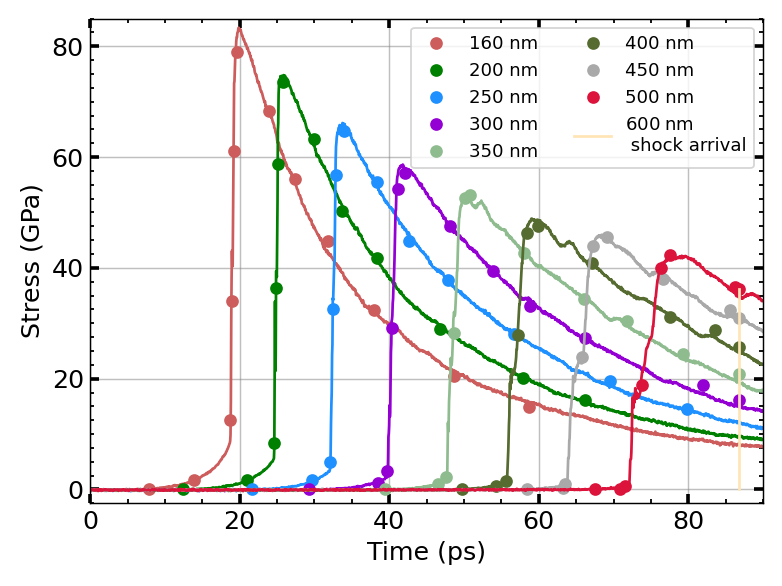

In [80]:
fit_sigma_time_window = plt.figure(8)
sigma_t_window = fit_sigma_time_window.add_subplot(111)

In [81]:
sigma_t_window.clear()
N = None
plot_range= [1,2,3,4,5,6,7,8]
i_variation = 11


for i in plot_range:
    sigma_t_window.plot(timegrid_epsilon[i][:N], sigma[i][:N], 
                            label = str(int(1000*width_indexed[i]))+" nm", 
                            color = colors[NRP_h-i-1],
                            linestyle="",
                            marker='o')
    sigma_t_window.plot((dict_P_rho_t[str(int(1000*width_indexed[i]))])[:,0], 
                               (dict_P_rho_t[str(int(1000*width_indexed[i]))])[:,1],
                               linestyle="-",
                               color = colors[NRP_h-i-1])


sigma_t_window.plot(tij[0,0::NRP_t][-1]*np.ones(100),np.linspace(0, (sigma[i][:N])[-1], 100), 
            color ='moccasin',
            linestyle = '-',
            label="600$\;$nm \n shock arrival")

sigma_t_window.set_xlim((0,90))
#sigma_t_window.set_xticks(np.arange(0.8, 1.01, 0.05))

sigma_t_window.set_ylim((-2.5,85))

sigma_t_window.grid(color='grey', alpha=0.5)    

sigma_t_window.set_xlabel("Time (ps)", **csfont)
sigma_t_window.set_ylabel("Stress (GPa)", **csfont)

sigma_t_window.legend(ncol=2)
subplot_axes_ticks_tuning(sigma_t_window)
plt.tight_layout()
sigma_t_window.yaxis.set_major_locator(MultipleLocator(20))
sigma_t_window.yaxis.set_minor_locator(MultipleLocator(2.5))
if savefigures:
    fit_sigma_time_window.savefig(Path(work_dir+figures_folder+"/sigma_time.pdf"),
                             dpi=300,
                             format='pdf')


In [82]:
if savefigures:
    analasys_window.savefig(Path(work_dir+figures_folder+"/selected.pdf"), dpi=300, format='pdf')  

In [83]:
if savefigures:
    fit_t_window.savefig(Path(work_dir+figures_folder+"/th.pdf"), dpi=300, format='pdf')
    
    
    
if savefigures:
    main_window.savefig(Path(work_dir+figures_folder+"/readed.pdf"), dpi=300, format='pdf')

In [84]:
for width, t_ufs in dict_ufs_t.items():
    if width == '250' or width=='500':
        print(width," ",quad(univ_spl_dict_ufs_t[width],0, 33.98,
                              limit = 120 )[0])
        print(width," ",quad(univ_spl_dict_ufs_t[width],33.98, 79.87,
                              limit = 120 )[0])

250   4.358199069795571
250   69.28871728667376
500   -0.05093205029972153
500   11.0244319947362
